#### Enviroment

In [1]:
# Imports + Choose device
from unityagents import UnityEnvironment
import numpy as np

from collections import namedtuple, deque
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import random

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
env = UnityEnvironment(file_name="Banana.app")
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

Mono path[0] = '/Users/gerritdolderer/AI/DRL/p1_navigation/Banana.app/Contents/Resources/Data/Managed'
Mono config path = '/Users/gerritdolderer/AI/DRL/p1_navigation/Banana.app/Contents/MonoBleedingEdge/etc'


INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


In [3]:
# reset the environment
env_info = env.reset(train_mode=False)[brain_name]

# number of agents in the environment
print('Number of agents:', len(env_info.agents))

# number of actions
action_size = brain.vector_action_space_size
print('Number of actions:', action_size)

# examine the state space 
state = env_info.vector_observations[0]
print('States look like:', state)
state_size = len(state)
print('States have length:', state_size)

Number of agents: 1
Number of actions: 4
States look like: [1.         0.         0.         0.         0.84408134 0.
 0.         1.         0.         0.0748472  0.         1.
 0.         0.         0.25755    1.         0.         0.
 0.         0.74177343 0.         1.         0.         0.
 0.25854847 0.         0.         1.         0.         0.09355672
 0.         1.         0.         0.         0.31969345 0.
 0.        ]
States have length: 37


In [4]:
def take_random_action():
    env_info = env.reset(train_mode=False)[brain_name] # reset the environment
    state = env_info.vector_observations[0]            # get the current state
    score = 0                                          # initialize the score
    while True:
        action = np.random.randint(action_size)        # select an action
        env_info = env.step(action)[brain_name]        # send the action to the environment
        next_state = env_info.vector_observations[0]   # get the next state
        reward = env_info.rewards[0]                   # get the reward
        done = env_info.local_done[0]                  # see if episode has finished
        score += reward                                # update the score
        state = next_state
        print(state)
                                # roll over the state to next time step
        if done:                                       # exit loop if episode finished
            break
        
    print("Score: {}".format(score))

#### The Neural Network class that trains on Q

In [5]:
class QNetwork(nn.Module):
    """Actor (Policy) Model."""
    """Dueling Network that maps state -> Expected Return, Advantage -> action values."""

    def __init__(self, state_size, action_size, seed, fc1_units=128, fc2_units=128, fc3_units = 64):
        super(QNetwork, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size, fc1_units)
        self.fc2 = nn.Linear(fc1_units, fc2_units)
        self.fc3 = nn.Linear(fc2_units, fc3_units)
        
        # Separate streams for value and advantage
        self.value_stream = nn.Linear(fc3_units, 1)
        self.advantage_stream = nn.Linear(fc3_units, action_size)

    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        
        # Compute value and advantage
        value = self.value_stream(x)
        advantage = self.advantage_stream(x)
        
        # Combine value and advantage to get Q-values
        q_values = value + (advantage - advantage.mean(dim=1, keepdim=True))
        return q_values


#### Replay Buffer that the Agent will use

In [6]:
class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, action_size, buffer_size, batch_size, seed):
        """Initialize a ReplayBuffer object.

        Params
        ======
            action_size (int): dimension of each action
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
            seed (int): random seed
        """
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)  
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)
    
    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)
    
    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)
  
        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

#### The Agent that will train and act on the enviroment

In [7]:
BUFFER_SIZE = 50000     # replay buffer size -> can look 700 episodes in the past
BATCH_SIZE = 64        # minibatch size 
GAMMA = 0.99           # discount factor
TAU = 0.001           # for soft update of target parameters
LR = 0.0015             # learning rate 
UPDATE_EVERY = 4        # how often to update the network
class Agent():
# Uses Memory Buffer, Double DQN, Dueling DQN
    def __init__(self, state_size, action_size, seed):
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(seed)
        self.t_step = 0

        # -------------- Local & Target Network + Replay Memory -------------- #
        self.qnetwork_local = QNetwork(state_size, action_size, seed).to(device)
        self.qnetwork_target = QNetwork(state_size, action_size, seed).to(device)
        self.optimizer = optim.Adam(self.qnetwork_local.parameters(), lr=LR)
        self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, seed)


    ### Let the local Network predict the next move and choose the epsilon-greedy policy
    def act(self, state, eps=0.):
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        self.qnetwork_local.eval()
        
        with torch.no_grad():
            action_values = self.qnetwork_local(state)
        self.qnetwork_local.train()

        if random.random() > eps:
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.action_size))

    ### Add the SARSA-tuple to memory. Learn from the memory every few steps.
    def step(self, state, action, reward, next_state, done):   
        self.memory.add(state, action, reward, next_state, done)
        
        self.t_step = (self.t_step + 1) % UPDATE_EVERY
        if self.t_step == 0:
            if len(self.memory) > BATCH_SIZE:
                self.learn(self.memory.sample(), GAMMA)


    ### from Batch of SARSD-tuples: Target network predicts next Q Target, local Network trains on Target network predictions, softupdate Targetnetwork
    def learn(self, experiences, gamma):

        states, actions, rewards, next_states, dones = experiences

        # Get max predicted Q values for next states from target model
        # using Double-DQN: instead of target model for both -> Get the best action from the local model and predict the value from target model.
        best_actions = self.qnetwork_local(next_states).detach().argmax(1).unsqueeze(1)
        Q_targets_next = self.qnetwork_target(next_states).gather(1, best_actions).detach()

        # Compute Q targets for current states 
        Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))

        # Get expected Q values from local model
        Q_expected = self.qnetwork_local(states).gather(1, actions)

        # Compute loss and propagate local model Backwards
        loss = F.mse_loss(Q_expected, Q_targets)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # ------------------- update target network ------------------- #
        self.soft_update(self.qnetwork_local, self.qnetwork_target, TAU)                     

    # Slowly update the target weights from the local weights
    def soft_update(self, local_model, target_model, tau):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target

        Params
        ======
            local_model (PyTorch model): weights will be copied from
            target_model (PyTorch model): weights will be copied to
            tau (float): interpolation parameter 
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)

In [8]:
agent = Agent(state_size=state_size, action_size=action_size, seed=0)

#### Training the Agent

In [9]:
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(agent.optimizer, mode='max', factor=0.75, patience=3)

def train(n_episodes=1000, eps_start=1, eps_end=0.01, eps_decay=0.995):
    scores = [] 
    scores_window = deque(maxlen=100) 
    average_scores = []  
    eps = eps_start  

    for idx_episode in range(1, n_episodes + 1):
        env_info = env.reset(train_mode=True)[brain_name]
        state = env_info.vector_observations[0]
        score = 0
        while True:
            action = agent.act(state, eps)                      # Select an action
            env_info = env.step(action)[brain_name]             # Send the action to the environment
            reward = env_info.rewards[0]                        # Get the reward
            next_state = env_info.vector_observations[0]        # Get the next state
            done = env_info.local_done[0]                       # See if episode has finished
            agent.step(state, action, reward, next_state, done) # Remember SARSD and learn from memory
            state = next_state
            score += reward
            if done:
                break
        scores_window.append(score)
        scores.append(score) 

        current_lr = agent.optimizer.param_groups[0]['lr']
        print(f'\rEpisode {idx_episode}\tScore: {score:.2f}\tAverage Score: {np.mean(scores_window):.2f}\tLearning Rate: {current_lr:.6f}\tEpsilon: {eps:.6f}', end="")

        if idx_episode % 100 == 0:
            average_score = np.mean(scores_window)
            print(f'\rEpisode {idx_episode}\tScore: {score:.2f}\tAverage Score: {average_score:.2f}\tLearning Rate: {current_lr:.6f}\tEpsilon: {eps:.6f}')
            average_scores.append(average_score)  
            scheduler.step(average_score)

        eps = max(eps_end, eps_decay * eps)

        if np.mean(scores_window) >= 13.0:
            print(f'\nEnvironment solved in {idx_episode - 100} episodes!\tAverage Score: {np.mean(scores_window):.2f}')
            torch.save(agent.qnetwork_local.state_dict(), 'checkpoint.pth')
            break

    torch.save(agent.qnetwork_local.state_dict(), 'checkpoint.pth')

    return scores, average_scores


Episode 100	Score: 12.00	Average Score: 3.00	Learning Rate: 0.001500	Epsilon: 0.050000
Episode 200	Score: 15.00	Average Score: 7.89	Learning Rate: 0.001500	Epsilon: 0.050000
Episode 300	Score: 11.00	Average Score: 9.48	Learning Rate: 0.001500	Epsilon: 0.050000
Episode 400	Score: 16.00	Average Score: 10.62	Learning Rate: 0.001500	Epsilon: 0.050000
Episode 500	Score: 6.00	Average Score: 12.80	Learning Rate: 0.001500	Epsilon: 0.0500000
Episode 510	Score: 12.00	Average Score: 13.01	Learning Rate: 0.001500	Epsilon: 0.050000
Environment solved in 410 episodes!	Average Score: 13.01


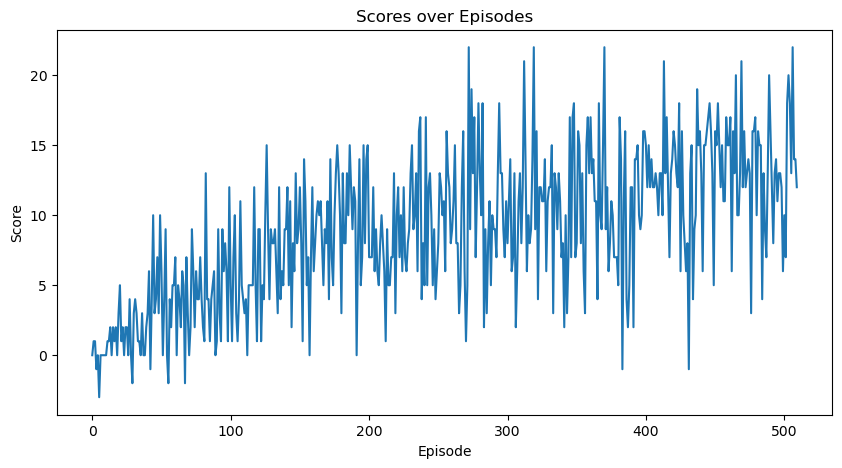

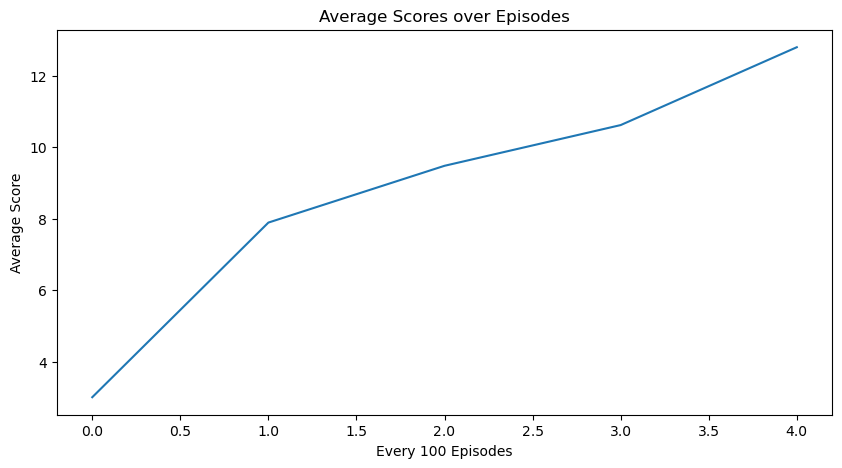

In [10]:
# Train the agent and get the scores and average scores
scores, average_scores = train(n_episodes=50000, eps_start=1, eps_end=0.05, eps_decay=0.95)

# Plot the scores
plt.figure(figsize=(10, 5))
plt.plot(scores)
plt.xlabel('Episode')
plt.ylabel('Score')
plt.title('Scores over Episodes')
plt.show()

# Plot the average scores
plt.figure(figsize=(10, 5))
plt.plot(average_scores)
plt.xlabel('Every 100 Episodes')
plt.ylabel('Average Score')
plt.title('Average Scores over Episodes')
plt.show()

#### Watch the Agent!

In [11]:
def load_model(filepath='checkpoint.pth'):
    """Load the model from a checkpoint file."""
    agent.qnetwork_local.load_state_dict(torch.load(filepath))
    agent.qnetwork_target.load_state_dict(torch.load(filepath))

In [12]:
def watch(n_episodes=3, eps=0.0, filepath='checkpoint.pth'):
    """Watch the agent's performance in the environment."""
    load_model(filepath)

    for idx_episode in range(1, n_episodes + 1):
        env_info = env.reset(train_mode=False)[brain_name]
        state = env_info.vector_observations[0]
        score = 0
        while True:
            action = agent.act(state, eps)                   # Select an action
            env_info = env.step(action)[brain_name]          # Send the action to the environment
            reward = env_info.rewards[0]                     # Get the reward
            next_state = env_info.vector_observations[0]     # Get the next state
            done = env_info.local_done[0]                    # See if episode has finished
            state = next_state
            score += reward
            if done:
                break
        print('\rEpisode {}\tScore: {:.2f}'.format(idx_episode, score), end="")

watch()

Episode 3	Score: 17.00